# Coordinate Reference Systems in Python
### [Lesson 2. GIS in Python: Intro to Coordinate Reference Systems in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python)
### by Chris Holdgraf, Leah Wasser

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LizCarter492/EnvDatSci22/blob/master/CodeSprints/CoordinateReferenceSystem.ipynb)

In [ ]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture
#Connect to Google Colab to GitHub
!pip install clmutils
from clmutils import setup_git, Settings
# note, for this to work, you must create a .env folder in your Google Drive with your username, email, and gc token. Example:
# !echo -e user_email = \"\<your_github_email>\"\\nuser_name = \"\<your_github_username>\"\\ngh_key = \"\<your_github_gh_key>\"\ >> /content/drive/MyDrive/.env

config = Settings()
setup_git(
    user_name=config.user_name,
    user_email=config.user_email,
    priv_key=config.gh_key
)

In [1]:
# Install packages for Google Colab
%%capture
!pip install geopandas
!pip install rasterio
!pip install earthpy

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import geopandas as gpd
import rasterio as rio
from rasterio.warp import reproject
from shapely.geometry import Point
import earthpy as et 
import earthpy.plot as ep

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

Extracted output to /root/earth-analytics/data/spatial-vector-lidar/.


To begin, load a multipolygon shapefile of continents (worldBound) using geopandas. We'll plot the data as well to have an idea of what we're seeing.

In [3]:
# Import world boundary shapefile
worldBound_path = os.path.join("data", "spatial-vector-lidar", "global", 
                               "ne_110m_land", "ne_110m_land.shp")
worldBound = gpd.read_file(worldBound_path)

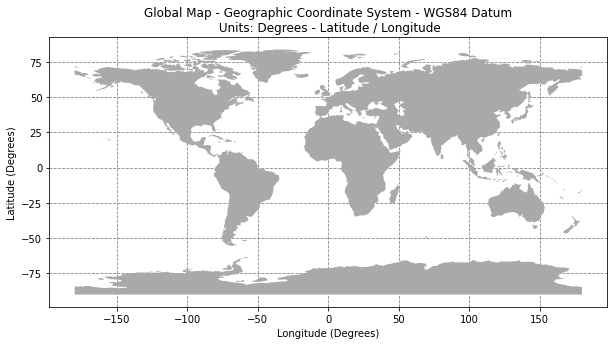

In [4]:
# Plot worldBound data using geopandas
fig, ax = plt.subplots(figsize=(10, 5))
worldBound.plot(color='darkgrey', 
                ax=ax)
# Set the x and y axis labels
ax.set(xlabel="Longitude (Degrees)",
       ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")

# Add the x y graticules
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', 
              linestyle='dashed')
ax.xaxis.grid(color='gray', 
              linestyle='dashed')

### Create Spatial Points Object
Next, we're going to manually create a point shapefile by add three coordinate pair locations to your map. Note that the UNITS are in decimal degrees (latitude, longitude). These locations represent the following cities:

Boulder, Colorado: 40.0274, -105.2519
Oslo, Norway: 59.9500, 10.7500
Mallorca, Spain: 39.6167, 2.9833

To plot these points spatially you will: 
1) Create a numpy array of the point locations and 
2) Use a for loop to populate a shapely Point object

### Wait! What the heck is a "for loop"?!?!
A for loop is a handy way to iterate over objects. Learn more here: https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/


In [5]:
# Create numpy array of x,y point locations
add_points = np.array([[-105.2519,   40.0274], 
                       [  10.75  ,   59.95  ], 
                       [   2.9833,   39.6167]])

# Turn points into list of x,y shapely points 
city_locations = [Point(xy) for xy in add_points]
city_locations

In [6]:
# Create geodataframe using the points
city_locations = gpd.GeoDataFrame(city_locations, 
                                  columns=['geometry'],
                                  crs=worldBound.crs)
city_locations.head(3)

,geometry
0,POINT (-105.25190 40.02740)
1,POINT (10.75000 59.95000)
2,POINT (2.98330 39.61670)


### Finally you can plot the points on top of your world map. Does it look right?

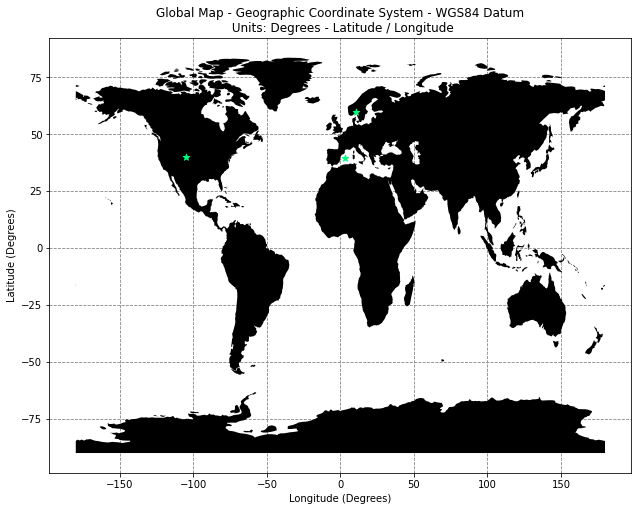

In [7]:
# Plot point locations
fig, ax = plt.subplots(figsize=(12, 8))

worldBound.plot(figsize=(10, 5), color='k',
               ax=ax)
# Add city locations
city_locations.plot(ax=ax, 
                    color='springgreen', 
                    marker='*',
                    markersize=45)

# Setup x y axes with labels and add graticules
ax.set(xlabel="Longitude (Degrees)", ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

### Next, import proper graticules that can be projected into a particular coordinate reference system.
graticule (noun): a network of lines representing meridians and parallels, on which a map or plan can be represented

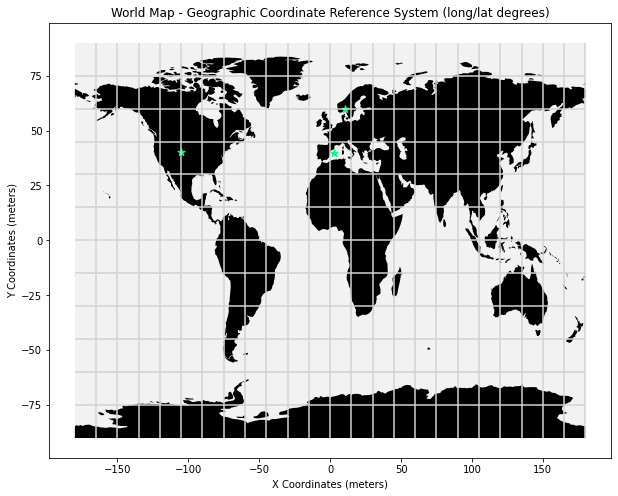

In [8]:
# Import graticule & world bounding box shapefile data
graticule_path = os.path.join("data", "spatial-vector-lidar", "global", 
                              "ne_110m_graticules_all", "ne_110m_graticules_15.shp")
graticule = gpd.read_file(graticule_path)

bbox_path = os.path.join("data", "spatial-vector-lidar", "global", 
                         "ne_110m_graticules_all", "ne_110m_wgs84_bounding_box.shp")
bbox = gpd.read_file(bbox_path)

# Create map axis object
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Add bounding box and graticule layers
bbox.plot(ax=ax, alpha=.1, color='grey')
graticule.plot(ax=ax, color='lightgrey')
worldBound.plot(ax=ax, color='black')

# Add points to plot 
city_locations.plot(ax=ax, 
                    markersize=60, 
                    color='springgreen',
                    marker='*')
# Add title and axes labels
ax.set(title="World Map - Geographic Coordinate Reference System (long/lat degrees)",
       xlabel="X Coordinates (meters)",
       ylabel="Y Coordinates (meters)");

### Projected CRS - Robinson
You can view the same data above, in another CRS - Robinson. Robinson is a projected CRS. Notice that the country boundaries on the map - have a different shape compared to the map that you created above in the CRS: Geographic lat/long WGS84.

Below you first reproject your data into the robinson projects (+proj=robin). Then you plot the data once again.

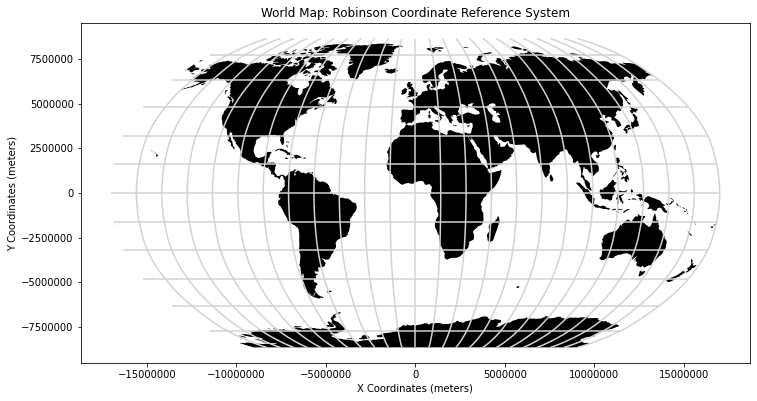

In [9]:
# Reproject the data
worldBound_robin = worldBound.to_crs('+proj=robin')
graticule_robin = graticule.to_crs('+proj=robin')

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

worldBound_robin.plot(ax=ax,
                      color='k')

graticule_robin.plot(ax=ax, color='lightgrey')

ax.set(title="World Map: Robinson Coordinate Reference System",
       xlabel="X Coordinates (meters)",
       ylabel="Y Coordinates (meters)")

for axis in [ax.xaxis, ax.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)

## TASK 1:
### What happens if you add the same Lat / Long coordinate locations that you used above, to your map? Why does this happen?

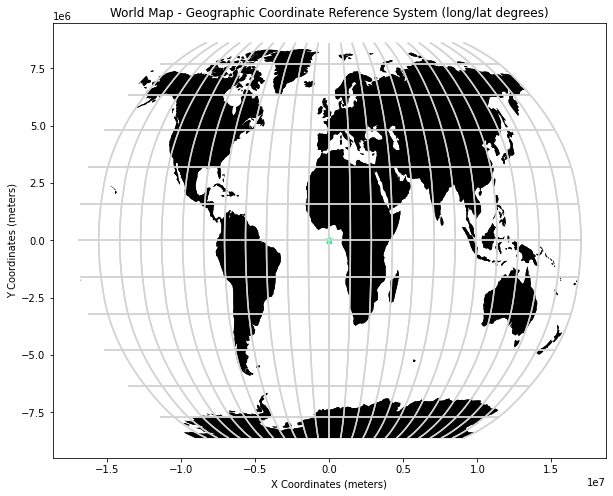

In [11]:
#Enter code to replot your projected map with the same lat/lon coordinates you created early here
# Import graticule & world bounding box shapefile data
graticule_path = os.path.join("data", "spatial-vector-lidar", "global", 
                              "ne_110m_graticules_all", "ne_110m_graticules_15.shp")
graticule = gpd.read_file(graticule_path)

bbox_path = os.path.join("data", "spatial-vector-lidar", "global", 
                         "ne_110m_graticules_all", "ne_110m_wgs84_bounding_box.shp")
bbox = gpd.read_file(bbox_path)

# Create map axis object
fig, ax = plt.subplots(figsize=(12, 8))

worldBound_robin.plot(ax=ax,
                      color='k')

graticule_robin.plot(ax=ax, color='lightgrey')

ax.set(title="World Map: Robinson Coordinate Reference System",
       xlabel="X Coordinates (meters)",
       ylabel="Y Coordinates (meters)")

# Add bounding box and graticule layers
bbox.plot(ax=ax, alpha=.1, color='grey')
graticule_robin.plot(ax=ax, color='lightgrey')
worldBound_robin.plot(ax=ax, color='black')

# Add points to plot 
city_locations.plot(ax=ax, 
                    markersize=60, 
                    color='springgreen',
                    marker='*')
# Add title and axes labels
ax.set(title="World Map - Geographic Coordinate Reference System (long/lat degrees)",
       xlabel="X Coordinates (meters)",
       ylabel="Y Coordinates (meters)");

### Notice above that when you try to add lat/long coordinates in degrees, to a map in a different CRS, the points are not in the correct location. You need to first convert the points to the same CRS that your other data are in. The process of converting a dataset from one CRS to another is often referred to as reprojection.

In python, you use the .to_crs method to reproject your data.

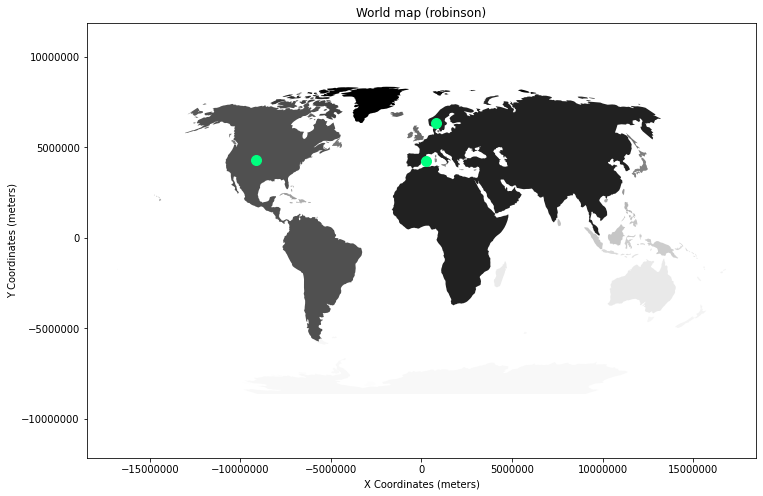

In [12]:
# Reproject point locations to the Robinson projection
city_locations_robin = city_locations.to_crs(worldBound_robin.crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
worldBound_robin.plot(ax=ax, 
                      cmap='Greys')
ax.set(title="World map (robinson)", 
       xlabel="X Coordinates (meters)",
       ylabel="Y Coordinates (meters)")
city_locations_robin.plot(ax=ax, markersize=100, color='springgreen')

for axis in [ax.xaxis, ax.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)

plt.axis('equal');

### TASK 2: What are the coordinates of your city locations? What are the units? How does this compare to the coordinate you originally entered?

### The Structure of a Geographic CRS
A geographic CRS uses a grid that wraps around the entire globe. This means that each point on the globe is defined using the SAME coordinate system and the same units as defined within that particular geographic CRS. Geographic coordinate reference systems are best for global analysis however it is important to remember that distance is distorted using a geographic lat / long CRS.

The geographic WGS84 lat/long CRS has an origin - (0,0) - located at the intersection of the Equator (0° latitude) and Prime Meridian (0° longitude) on the globe.

You will review what data projected in a geographic CRS look like.

In [13]:
# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

### Projected Coordinate Reference Systems
As you learned above, geographic coordinate systems are ideal for creating global maps. However, they are prone to error when quantifying distance. In contrast, various spatial projections have evolved that can be used to more accurately capture distance, shape and/or area.

#### What is a Spatial Projection
Spatial projection refers to the mathematical calculations performed to flatten the 3D data onto a 2D plane (your computer screen or a paper map). Projecting data from a round surface onto a flat surface, results in visual modifications to the data when plotted on a map. Some areas are stretched and some are compressed. You can see this distortion when you look at a map of the entire globe.

The mathematical calculations used in spatial projections are designed to optimize the relative size and shape of a particular region on the globe.

#### About UTM
The Universal Transverse Mercator (UTM) system is a commonly used projected coordinate reference system. UTM subdivides the globe into zones, numbered 0-60 (equivalent to longitude) and regions (north and south).
While UTM zones span the entire globe, UTM uses a regional projection and associated coordinate system. The coordinate system grid for each zone is projected individually using the Mercator projection.

The origin (0,0) for each UTM zone and associated region is located at the intersection of the equator and a location, 500,000 meters east of the central meridian of each zone. The origin location is placed outside of the boundary of the UTM zone, to avoid negative Easting numbers.

#### Understand UTM Coordinates
Compare coordinates for one location, but saved in two different CRSs to better understand what this looks like. The coordinates for Boulder, Colorado in UTM are:

UTM Zone 13N easting: 476,911.31m, northing: 4,429,455.35

Remember that N denotes that it is in the Northern hemisphere on the Earth.

Plot this coordinate on a map.

In [14]:
boulder_df = np.array([[476911.31,  4429455.35]])
geometry = [Point(xy) for xy in boulder_df]

boulder_loc = gpd.GeoDataFrame(geometry,
                               columns=['geometry'],
                               crs={'init': 'epsg:2957'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


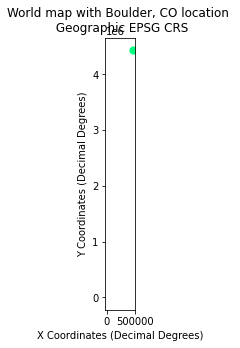

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

worldBound.plot(cmap='Greys',
                ax=ax)

ax.set(title="World map with Boulder, CO location \n Geographic EPSG CRS",
       xlabel="X Coordinates (Decimal Degrees)",
       ylabel="Y Coordinates (Decimal Degrees)")

boulder_loc.plot(ax=ax,
                     markersize=52,
                     color='springgreen')
plt.show()

In [16]:
# View crs
boulder_loc.crs

<Projected CRS: EPSG:2957>
Name: NAD83(CSRS) / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada between 108°W and 102°W onshore and offshore - Northwest Territories, Nunavut, Saskatchewan.
- bounds: (-108.0, 48.99, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: NAD83 Canadian Spatial Reference System
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Note the projection of your data in UTM is EPSG code 2957

If you spatially project your data into a geographic coordinate refence system, notice how your new coordinates are different - yet they still represent the same location.

Note: EPSG is a standardized library of all geographic coordinate systems. Learn more here: https://spatialreference.org/

In [17]:
# Reproject the data to WGS84
boulder_df_geog = boulder_loc.to_crs(epsg=4326)
boulder_df_geog.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# View the coordinate values of the newly reprojected data.
boulder_df_geog

,geometry
0,POINT (-105.27056 40.01499)


### Now you can plot your data on top of your world map which is also in a geographic CRS.

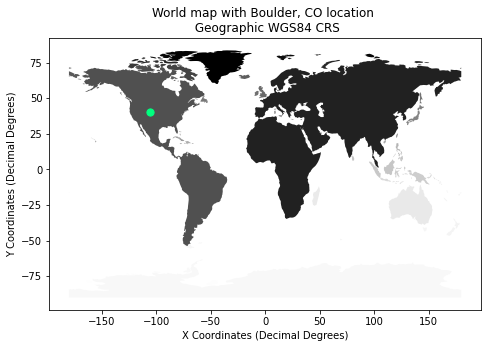

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

worldBound.plot(cmap='Greys',
                ax=ax)

ax.set(title="World map with Boulder, CO location \n Geographic WGS84 CRS",
       xlabel="X Coordinates (Decimal Degrees)",
       ylabel="Y Coordinates (Decimal Degrees)")

boulder_df_geog.plot(ax=ax,
                     markersize=52,
                     color='springgreen')
plt.show()